In [1]:
import nmp_util as nmp_util
import sympy
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
data = pd.read_csv('SeaLevel_exclGIA.txt', names = ['date [y]','rise [mm]'], delimiter = r'\s+')
display(data)

,date [y],rise [mm]
0,1993.011526,-37.91
1,1993.038692,-40.95
2,1993.065858,-41.09
3,1993.093025,-43.38
4,1993.120191,-38.66
...,...,...
1173,2024.882992,70.97
1174,2024.910084,67.60
1175,2024.937176,65.14
1176,2024.964267,66.41


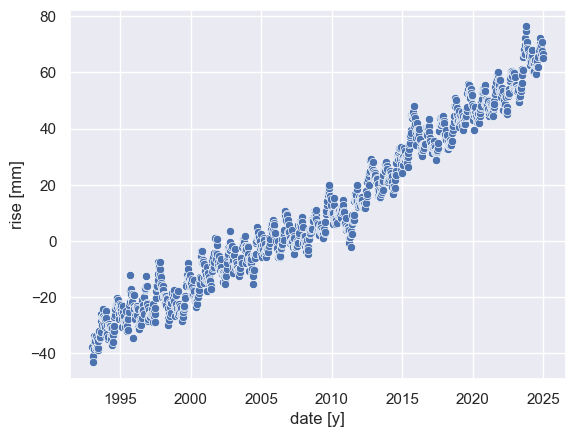

datapoints : 1178


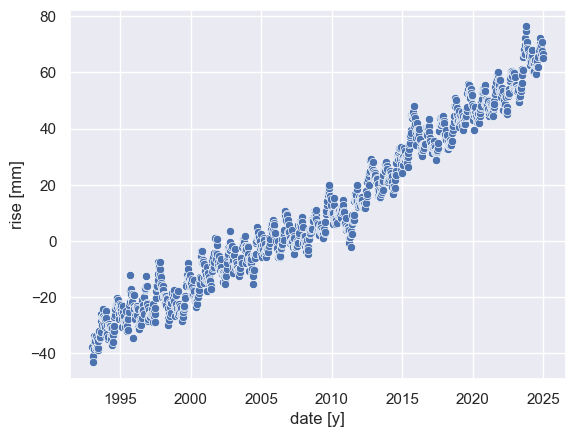

datapoings: 1178


In [3]:
sns.scatterplot(data = data, x = 'date [y]', y = 'rise [mm]')
plt.show()
print(f'datapoints : {len(data)}')
data = data.loc[nmp_util.get_inliers(data['rise [mm]']) & nmp_util.get_inliers(data['date [y]'])]
sns.scatterplot(data = data, x = 'date [y]', y = 'rise [mm]')
plt.show()
print(f'datapoings: {len(data)}')

mean : 11.139906621392191
standard deviation : 29.023724612643935


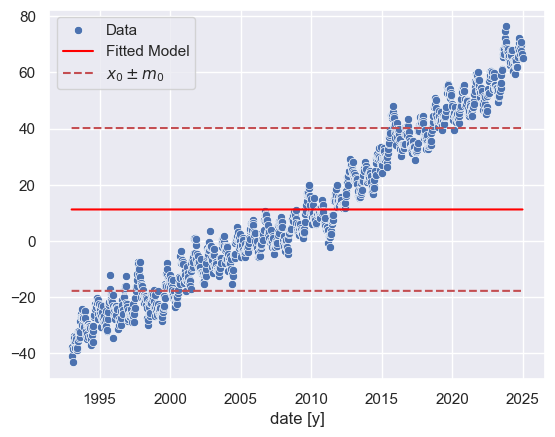

In [23]:
zero_order = nmp_util.PolyFunctionalModel(0)

zero_order.fit(data['date [y]'], data['rise [mm]'])


zero_order.plot()
sns.lineplot(x = data['date [y]'], y = zero_order.parameters[0]+zero_order.m_0, linestyle = '--',c='r')
sns.lineplot(x = data['date [y]'], y = zero_order.parameters[0]-zero_order.m_0, linestyle = '--', label = '$x_0\\pm m_0$',c='r')
plt.legend()
offset = zero_order.parameters[0]

display(zero_order)

print(f'mean : {data["rise [mm]"].mean()}')
print(f'standard deviation : {data["rise [mm]"].std()}')
plt.show()

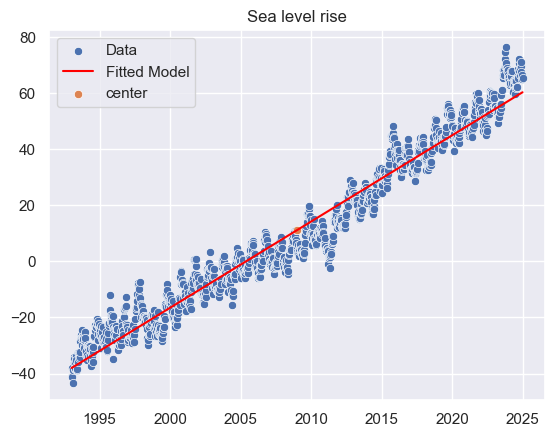

In [5]:
first_order = nmp_util.PolyFunctionalModel(1)

first_order.fit(data['date [y]'], data['rise [mm]'])

x_center = data['date [y]'].mean()
y_center = data['rise [mm]'].mean()

data['linear fit [mm]'] = first_order(data['date [y]'])

plt.title('Sea level rise')
first_order.plot()
sns.scatterplot(x = [x_center], y = [y_center], label = 'center')
plt.show()


y_pred = np.polyval(first_order.parameters, x_center)
assert np.isclose(y_pred, y_center)

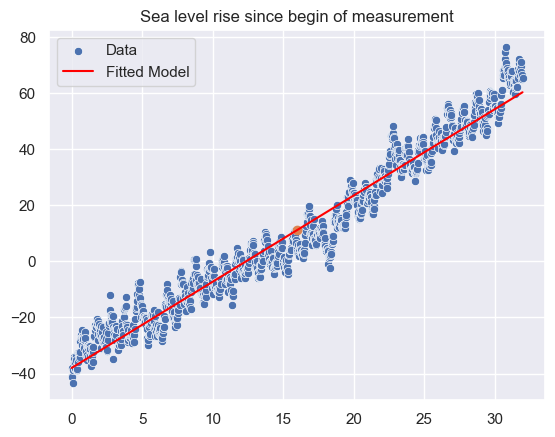

In [18]:
data['relative date [y]'] = data['date [y]'] - data['date [y]'].min()

first_order.fit(data['relative date [y]'], data['rise [mm]'])

display(first_order)

x_center = data['relative date [y]'].mean()
y_center = data['rise [mm]'].mean()

data['linear fit [mm]'] = first_order(data['relative date [y]'])
plt.title('Sea level rise since begin of measurement')
first_order.plot()
plt.scatter(x_center, y_center, label = 'center')
plt.show()

y_pred = np.polyval(first_order.parameters, x_center)
assert np.isclose(y_pred, y_center)

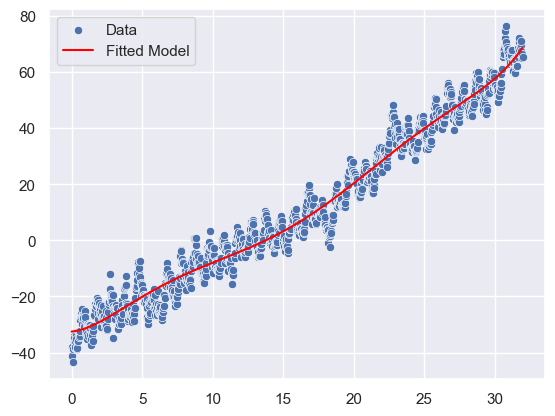

In [17]:
order = 6

poly_model = nmp_util.PolyFunctionalModel(order)

poly_model.fit(data['relative date [y]'], data['rise [mm]'])

display(poly_model)

data['poly fit [mm]'] = poly_model(data['relative date [y]'])

poly_model.plot()
plt.show()

In [8]:
m_0_alternative = np.sqrt(((data['rise [mm]']**2).sum() - (data['rise [mm]']*data['poly fit [mm]']).sum()) / (len(data) - order))

print(m_0_alternative)
print(poly_model.m_0)

4.94584223165279
4.947953583737729


# Let's compare the explicit and implicit methods, also check if the sympy method gives the same result

In [9]:
np.random.seed(1)
x = np.random.random(1000)
y = np.random.random(1000)
degree = 7

direct = nmp_util.PolyFunctionalModel(degree, 'direct')
direct.fit(x, y)

design_matrix = nmp_util.PolyFunctionalModel(degree, 'design matrix')
design_matrix.fit(x, y)

x_sym = sympy.Symbol('x')
a_gen = sympy.numbered_symbols('a', start=0) 
a_i = [next(a_gen) for _ in range(degree+1)]
function = sum(a_i[i] * x_sym**i for i in range(degree+1))

sympy_model = nmp_util.SympyFunctionalModel(function, list(reversed(a_i)), x_sym)
sympy_model.fit(x, y)


assert np.allclose(direct.parameters, design_matrix.parameters), 'The methods are not equivalent!'
assert np.allclose(direct.normal_matrix, design_matrix.normal_matrix), 'The methods are not equivalent!'
assert np.allclose(direct.parameters, sympy_model.parameters), 'The methods are not equivalent!'
assert np.allclose(direct.normal_matrix, sympy_model.normal_matrix), 'The methods are not equivalent!'

print('The methods are equivalent!')

The methods are equivalent!


In [10]:
N = 500_000
test_x = np.random.rand(N)
test_y = np.random.rand(N)
order = 10

In [11]:
%timeit -n 10 -r 10 design_matrix.fit(test_x, test_y)
%timeit -n 10 -r 10 direct.fit(test_x, test_y)

217 ms ± 3.74 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
359 ms ± 8.6 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


# How fast is the poly fit if we use a P matrix?

In [12]:
import scipy.sparse
diag_elements = np.random.rand(N)
P = scipy.sparse.diags(diag_elements)
%timeit -r 10 design_matrix.fit(test_x, test_y, P)

try:
    P = P.todense()
    %timeit -r 10 design_matrix.fit(test_x, test_y, P)
except Exception as e:
    print(e)
    print('P is too large to convert to dense matrix.')

201 ms ± 5.71 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Unable to allocate 1.82 TiB for an array with shape (500000, 500000) and data type float64
P is too large to convert to dense matrix.


# Test the sympy model

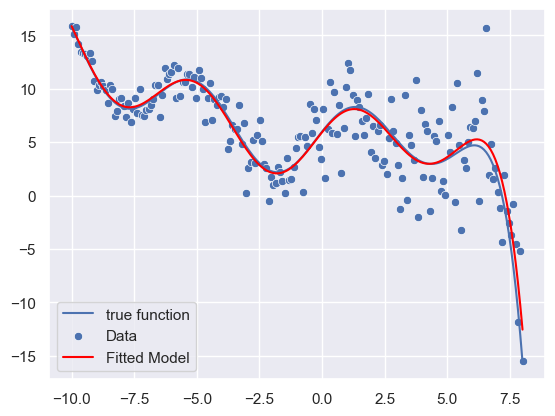

(np.float64(211.41603674790366), np.float64(228.57993801830452))
1.0841848038354034


In [ ]:
import sympy

true_params = np.array([3, 1, 0.1, -0.01, 5])

a, b, c, d, e, x = sympy.symbols('a, b, c, d, e, x')

function = a * sympy.sin(x) + b * sympy.cos(x) + c * x ** 2 + d * sympy.exp(x) + e

N = 200

x_vals = np.linspace(-10, 8, N)
true_y : np.ndarray = sympy.lambdify([a, b, c, d, e, x], function)(*true_params, x_vals)

sns.lineplot(x = x_vals, y = true_y, label = 'true function')



sigma_0 = 4

cofactors = np.linspace(0.1,1,N)

measured_y = true_y + np.random.normal(0, sigma_0, N) * cofactors

sympy_model = nmp_util.SympyFunctionalModel(function, [a, b, c, d, e], x)
sympy_model.fit(x_vals, measured_y, np.diag(1/cofactors**2))

sympy_model.plot()

plt.show()

print(sympy_model.chi2test(sigma_0=sigma_0))
print(sympy_model.m_0**2 / sigma_0**2)